In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

#from skimage.morphology import watershed
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import io
from skimage.filters import threshold_otsu
from skimage import morphology as mp
from skimage.util import invert
from skimage.util import img_as_ubyte
from skimage import exposure

Some functions for computing gradient and extracting extended regional minima

In [14]:
def sobel_mag(im):
    """
    Returns Sobel gradient magnitude
    im: image array of type float
    returns : magnitude of gradient (L2 norm)
    """
    dx = ndi.sobel (im, axis =1) # horizontal derivative
    dy = ndi.sobel (im, axis =0) # vertical derivative
    mag = np.hypot(dx, dy) # magnitude
    return mag;

def rmax(I):
    """
    regional maximum
    I: original image, int values
    returns: binary array, with True for the maxima
    """
    I = I.astype ('float');
    I = I / np.max(I)*2**31;
    I = I.astype ('int32');
    h = 1;
    rec = mp.reconstruction(I,I+h);
    #rec = mp.reconstruction(I+h,I,method='erosion');
    maxima = I + h - rec ;
    return maxima>0

In [3]:
im_org = io.imread('small_blobs.png')
im = np.copy(im_org)
SE = mp.disk(2);
O = mp.opening(im, selem=SE);
F = mp.closing(O, selem=SE).astype ('float') ;
g = sobel_mag(F).astype('float');
g_he = exposure.equalize_hist(g)

In [4]:
local_maxi = rmax(np.max(F) - F);
#local_maxi = peak_local_max(F, indices=False, exclude_border=0)
markers = ndi.label(local_maxi, np.ones((3,3)))[0]
W = watershed(F, markers, watershed_line=True)
markers2 = local_maxi | (W==0);
M = ndi.label(markers2, np.ones((3,3)))[0]
segmentation = watershed(g, M, watershed_line=True);
#segmentation = watershed(g, markers2, watershed_line=True);
im[segmentation==0] = 255;

Performing watershed transform on the gradient magnitude image. The result is over segmented due to the large number of regional minima in the gradient image. 

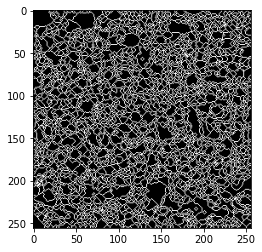

In [5]:
L = watershed(g, markers=None, watershed_line=True)
w_l = L==0
plt.imshow(w_l, cmap=plt.cm.gray)
plt.show()

We can see from the following image that why the watershed transform produced so many small catchment basins. Most of the local regional minima are shallow and represent details irrelevant to the region of intereest we are trying to segment. 

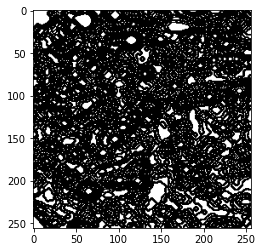

In [6]:
local_max = peak_local_max(-g, indices=False, exclude_border=0)
plt.imshow(local_max, cmap=plt.cm.gray)
plt.show()

Using threshold to select deep regional minima does not work well in this case

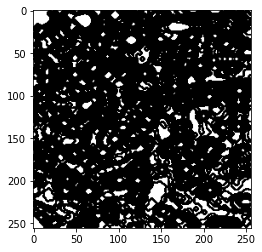

In [7]:
local_min_g = g < 0.5
plt.imshow(local_min_g, cmap=plt.cm.gray)
plt.show()

Using extended-minima transform gives better result. Now we have better regional minima that are relevant to our segmentation problem.

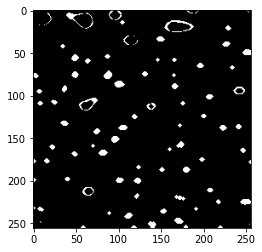

In [8]:
plt.imshow(local_maxi, cmap=plt.cm.gray)
plt.show()

Internal markers and external markers are combined here.

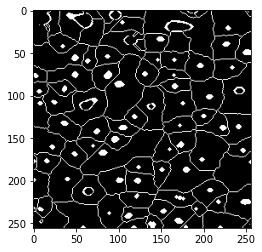

In [9]:
plt.imshow(markers2, cmap=plt.cm.gray)
plt.show()

Showing the external markers only

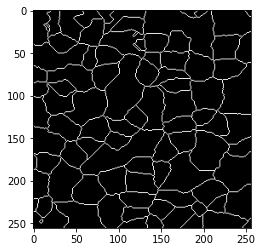

In [10]:
w_l_W = W==0
plt.imshow(w_l_W, cmap=plt.cm.gray)
plt.show()

Markers controlled watershed segmentation results in the following watershed lines

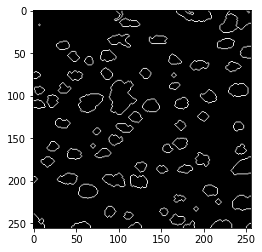

In [11]:
wl_seg = segmentation==0
plt.imshow(wl_seg, cmap=plt.cm.gray)
plt.show()

Imposing the watershed lines on the gradient image - shows the catchment basins found are mostly relevant to the region of interest. But there are some mistakes. 

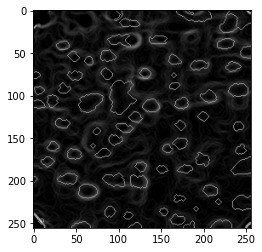

In [12]:
g_imp = g.copy()
g_imp[segmentation==0] = 255;
plt.imshow(g_imp, cmap=plt.cm.gray)
plt.show()

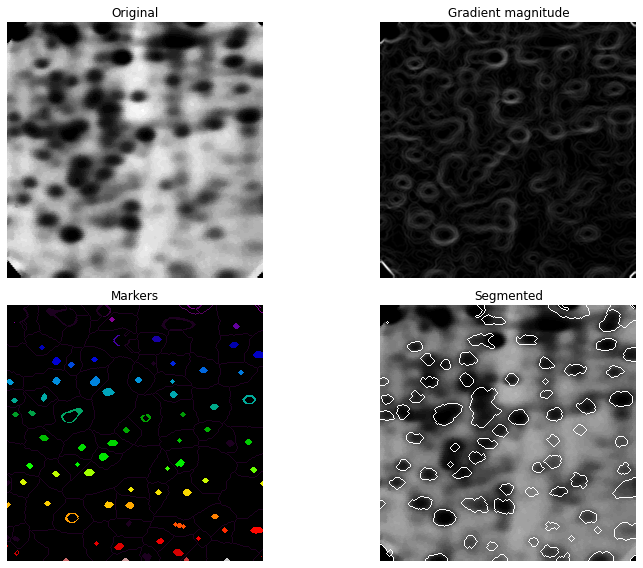

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im_org, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(g, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title("Gradient magnitude")

ax[2].imshow(M, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("Markers")

ax[3].imshow(im, cmap=plt.cm.gray, interpolation='nearest')
#ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()